##Import Libraries

In [200]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import plotly.express as px
from sklearn.exceptions import ConvergenceWarning
# Imports
import os
import pandas as pd
from pandas import Series, DataFrame

pd.set_option('display.max_rows', None,'display.max_columns', None)

sns.set_style('whitegrid')
%matplotlib inline

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, cross_validate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer

from scipy.stats import ks_2samp
#from treeinterpreter import treeinterpreter as ti

from sklearn.preprocessing import  StandardScaler
from sklearn.impute import SimpleImputer
#from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [201]:
### DATA

In [202]:
# Load the Data
df = pd.read_csv("data/loan.csv", low_memory=False)

In [203]:
#Preview the top 5 datasets
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,16901.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,NaN,2.0,NaN,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,1208.0,321915.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,NaN,4.0,NaN,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt cons

In [204]:
# Count of the dataset
df.shape[0]

2260668

In [205]:
#Predicting the Loan_status column, Checing the Target Value Counts
df['loan_status'].value_counts()

loan_status
Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: count, dtype: int64

In [206]:
df = df.loc[df['loan_status'].isin(['Fully Paid','Charged Off'])]
df['loan_status'].value_counts(normalize=False, dropna=False)

loan_status
Fully Paid     1041952
Charged Off     261655
Name: count, dtype: int64

In [207]:
#Data is Unbalanced, as About 80% (~1.04M) of the loans are Paid off. 20% (261k) have been charged off. 
#We will pick appropriate metrics to handle the balance issue in cross-validation.
df['loan_status'].value_counts(normalize=True, dropna=False)

loan_status
Fully Paid     0.799284
Charged Off    0.200716
Name: proportion, dtype: float64

In [208]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,url,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,0.0,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,0.0,1.303295e+06,1.303607e+06,1.303606e+06,645783.000000,221766.000000,1.303607e+06,1.303607e+06,1.303607e+06,1.302797e+06,1.303607e+06,1303607.0,1303607.0,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303551e+06,342367.000000,1303607.0,2.323700e+04,23235.000000,1.303607e+06,1.236080e+06,1.236080e+06,499544.000000,499545.000000,499545.000000,499545.000000,486548.000000,4.995450e+05,432668.000000,499545.000000,499545.000000,499545.000000,499494.000000,1.236080e+06,499545.000000,499544.000000,499544.000000,1.256326e+06,1.236059e+06,1.242968e+06,1.242221e+06,1.303551e+06,1.303607e+06,1.199312e+06,1.236079e+06,1.236079e+06,1.236080e+06,1.256326e+06,1.243866e+06,309146.000000,1.134058e+06,435835.000000,1.236080e+06,1.236080e+06,1.236080e+06,1.247766e+06,1.236080e+06,1.236080e+06,1.236080e+06,1.236079e+06,1.236080e+06,1.247766e+06,1.188037e+06,1.236080e+06,1.236080e+06,1.236080e+06,1.235926e+06,1.242560e+06,1.302910e+06,1.303568e+06,1.236080e+06,1.256326e+06,1.256326e+06,1.236080e+06,16510.000000,16511.000000,16511.000000,16511.000000,16218.000000,16511.000000,16511.000000,16511.000000,16511.000000,5932.000000,5335.0,5335.000000,5335.0,5335.000000,3433.000000,5335.000000,5335.000000,31989.000000,31989.000000,31989.000000
mean,NaN,NaN,1.441681e+04,1.440812e+04,1.438520e+04,1.325722e+01,4.380850e+02,7.615899e+04,NaN,1.825875e+01,3.176126e-01,6.591309e-01,34.320521,70.611712,1.159234e+01,2.155220e-01,1.623599e+04,5.191014e+01,2.501894e+01,0.0,0.0,1.479139e+04,1.476721e+04,1.216570e+04,2.388511e+03,1.548447e+00,2.356279e+02,3.910769e+01,5.467824e+03,1.699051e-02,43.686161,1.0,1.170146e+05,18.881760,5.069779e-03,2.494393e+02,1.410797e+05,1.057282,2.797708,0.783909,1.757351,19.417671,3.598134e+04,71.543488,1.428196,3.020244,5527.801201,58.231088,3.270816e+04,1.099465,1.623371,2.329849,4.696510e+00,1.348766e+04,1.012529e+04,6.007134e+01,9.079046e-03,1.505600e+01,1.258357e+02,1.814992e+02,1.308648e+01,7.841848e+00,1.676875e+00,2.378992e+01,39.688290,6.703453e+00,35.830532,5.093926e-01,3.642725e+00,5.646083e+00,4.732653e+00,8.122469e+00,8.574313e+00,8.281415e+00,1

In [209]:
list(df.columns)

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303607 entries, 100 to 2260664
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 1.4+ GB


In [291]:
#Define a function to visulize the features with missing values, and % of total values, & datatype
def missing_values_table(df):
     # Total missing values
    missing_val = df.isnull().sum()
    # Percentage of missing values
    missing_percent = 100 * df.isnull().sum() / len(df)
    missing_type = df.dtypes
    # Make a table with the results
    missing_val_tbl = pd.concat([missing_val, missing_percent, missing_type], axis=1)
        
     # Rename the columns
    mis_val_table_ren_columns = missing_val_tbl.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'type'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

missing_values_table(loandf)

Your selected dataframe has 145 columns.
There are 113 columns that have missing values.


,Missing Values,% of Total Values,type
id,2260668,100.0,float64
url,2260668,100.0,float64
member_id,2260668,100.0,float64
orig_projected_additional_accrued_interest,2252242,99.6,float64
hardship_length,2250055,99.5,float64
hardship_reason,2250055,99.5,object
hardship_status,2250055,99.5,object
deferral_term,2250055,99.5,float64
hardship_amount,2250055,99.5,float64
hardship_start_date,2250055,99.5,object


In [216]:
missing_frac = df.isnull().mean()
drop_list = sorted(missing_frac[missing_frac > 0.48].index)

In [217]:
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'id', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_o

In [218]:
len(drop_list)

58

In [219]:
def drop_cols(cols):
    df.drop(labels=cols, axis=1, inplace=True)

drop_cols(drop_list)

In [220]:
df.shape

(1303607, 87)

In [221]:
#For the defaulter population, we will remove all the features available BEFORE making the decision to lend the loan. After checking the features, we will drop the following -
drop_list = ['addr_state', 'zip_code','title','grade', 'emp_title','acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim']

len(drop_list)

61

In [222]:
drop_cols(drop_list)

In [223]:
print(sorted(df.columns))

['annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'home_ownership', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc', 'open_acc', 'policy_code', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'total_acc', 'verification_status']


In [224]:

len(df.columns)

26

In [225]:
df.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,policy_code,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies
count,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303295e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.302797e+06,1.303607e+06,1303607.0,1.199312e+06,1.236079e+06,1.256326e+06,1.302910e+06
mean,1.441681e+04,1.325722e+01,4.380850e+02,7.615899e+04,1.825875e+01,1.159234e+01,2.155220e-01,1.623599e+04,5.191014e+01,2.501894e+01,1.0,1.258357e+02,1.814992e+02,1.676875e+00,1.346985e-01
std,8.699542e+03,4.760544e+00,2.610632e+02,7.004890e+04,1.093849e+01,5.465282e+00,6.028619e-01,2.228629e+04,2.450155e+01,1.199584e+01,0.0,5.217895e+01,9.433621e+01,2.005056e+00,3.782756e-01
min,5.000000e+02,5.310000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.0,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+03,9.750000e+00,2.488200e+02,4.584000e+04,1.179000e+01,8.000000e+00,0.000000e+00,5.952000e+03,3.360000e+01,1.600000e+01,1.0,9.800000e+01,1.170000e+02,0.000000e+00,0.000000e+00
50%,1.200000e+04,1.274000e+01,3.754300e+02,6.500000e+04,1.761000e+01,1.100000e+01,0.000000e+00,1.114000e+04,5.230000e+01,2.300000e+01,1.0,1.290000e+02,1.640000e+02,1.000000e+00,0.000000e+00
75%,2.000000e+04,1.599000e+01,5.804500e+02,9.000000e+04,2.404000e+01,1.400000e+01,0.000000e+00,1.974800e+04,7.080000e+01,3.200000e+01,1.0,1.520000e+02,2.300000e+02,3.000000e+00,0.000000e+00
max,4.000000e+04,3.099000e+01,1.719830e+03,1.099920e+07,9.990000e+02,9.000000e+01,8.600000e+01,2.904836e+06,8.923000e+02,1.760000e+02,1.0,9.990000e+02,8.520000e+02,5.100000e+01,1.200000e+01


In [226]:
# make general plots to examine each feature
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,3))
    # plot1: counts distribution of the variable
    
    if continuous:  
        sns.histplot(df.loc[df[col_name].notnull(), col_name], ax=ax1, kde=True, stat="density", linewidth=0)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

          
    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        Charged_Off_rates = df.groupby(col_name)['loan_status'].value_counts(normalize=True)[:,'Charged Off']
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged Off')
        ax2.set_title('Charged Off Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
    # plot3: kde plot of the variable gropued by loan_status
    if continuous:  
        facet = sns.FacetGrid(df, hue = 'loan_status',  aspect=4)
        facet.map(sns.kdeplot, col_name, fill=True)
        #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='loan_status', data=df, order=sorted(df[col_name].unique()) )
     
    plt.tight_layout()


In [227]:
#1.IssuedDate: "The month which the loan was funded.
#issue_d will not be included in modeling, kept for train/test split only

df['issue_d'].sample(5)

2076649    Feb-2014
795679     Jan-2016
2046467    Apr-2014
1749885    Jul-2013
1705344    Oct-2013
Name: issue_d, dtype: object

In [228]:
#2.LoanAmount: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
df['loan_amnt'].describe()

count    1.303607e+06
mean     1.441681e+04
std      8.699542e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

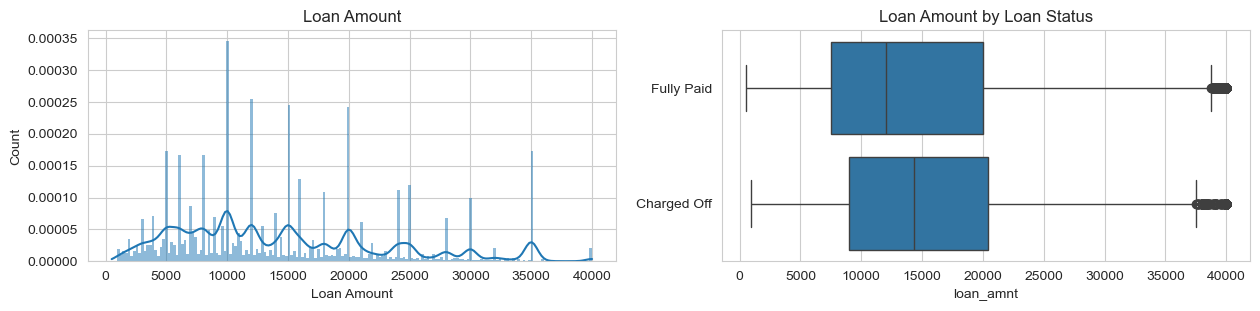

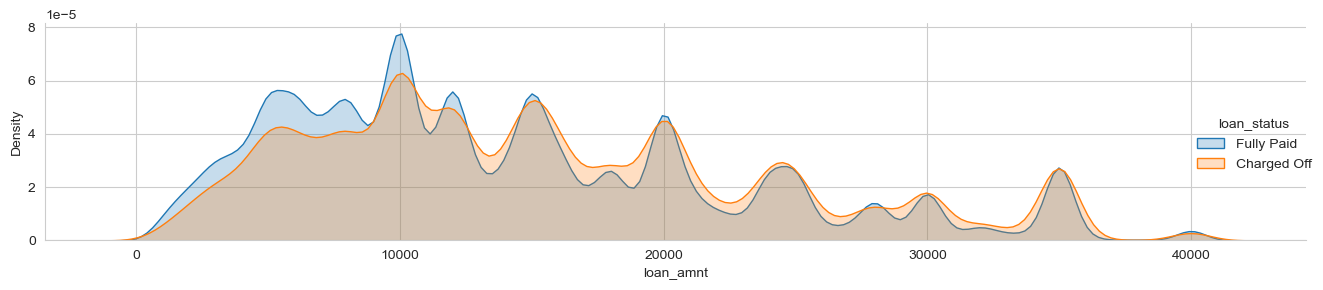

In [229]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

In [230]:
#3.ChargedOff: "The number of payments on the loan. Values are in months and can be either 36 or 60."
df['term'].sample(5)
df['term'].value_counts(dropna=False)
df['term'] = df['term'].apply(lambda s: np.int8(s.split()[0]))

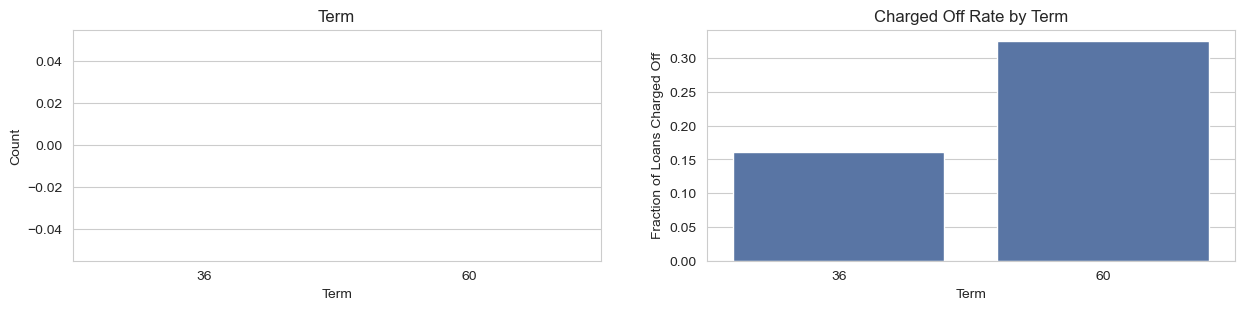

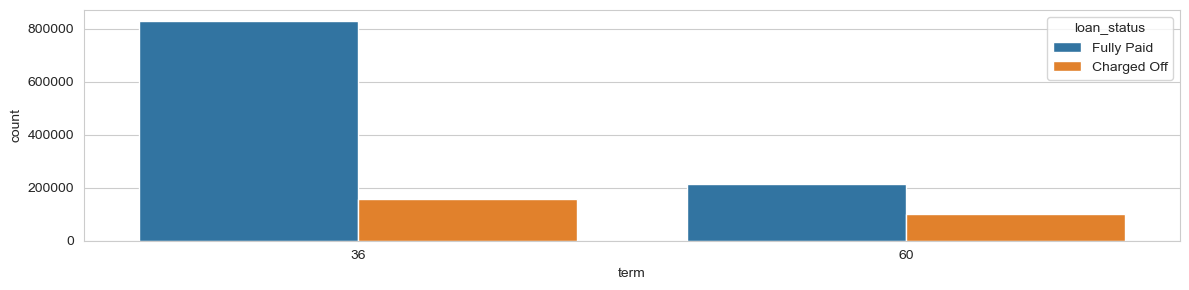

In [231]:
plot_var('term', 'Term', continuous=False)

In [232]:
df['term'].value_counts(normalize=True)
#About 76% of the loans are 36 months and the rest are 60 months. The latter tends to have lower fraction of being fully paid.

term
36    0.758476
60    0.241524
Name: proportion, dtype: float64

In [117]:
#17% of the 36-month loans are charge off, while 33% of the 60-month are charged off. Longer term leads to higher charged off? This feature should be useful in modeling.
df.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.160959
60    0.325568
Name: proportion, dtype: float64

In [118]:
#4.InterstRate: "Interest Rate on the loan."
df['int_rate'].describe()

count    1.303607e+06
mean     1.325722e+01
std      4.760544e+00
min      5.310000e+00
25%      9.750000e+00
50%      1.274000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

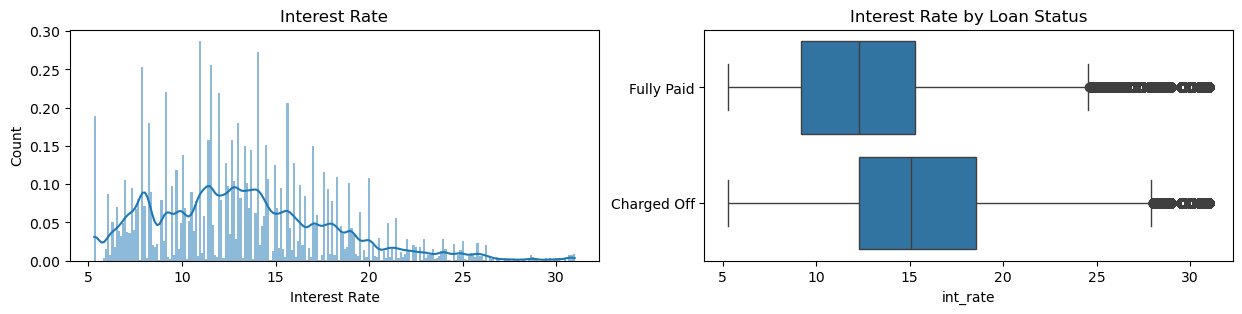

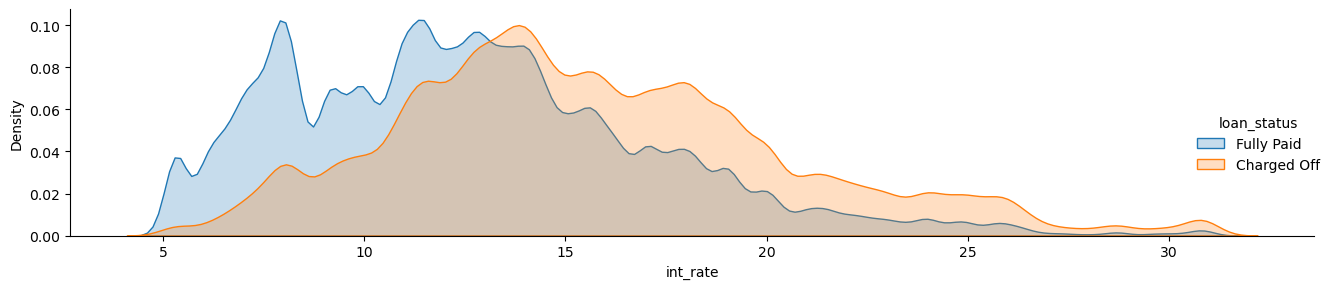

In [160]:
#The higher the interest rate is, the more likely for being charged off. There are some outliers in the Fully Paid dataset. 
plot_var('int_rate', 'Interest Rate', continuous=True)

In [233]:
#5.InterestRate: "The monthly payment owed by the borrower if the loan originates."
df['int_rate'].describe()

count    1.303607e+06
mean     1.325722e+01
std      4.760544e+00
min      5.310000e+00
25%      9.750000e+00
50%      1.274000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

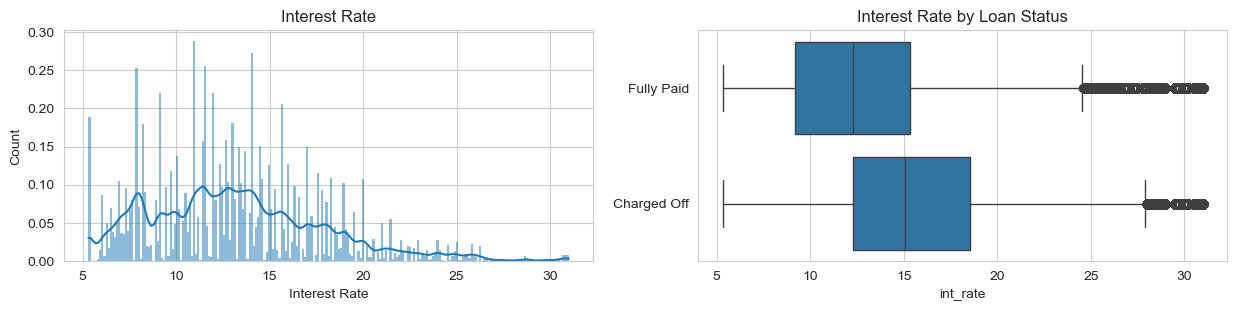

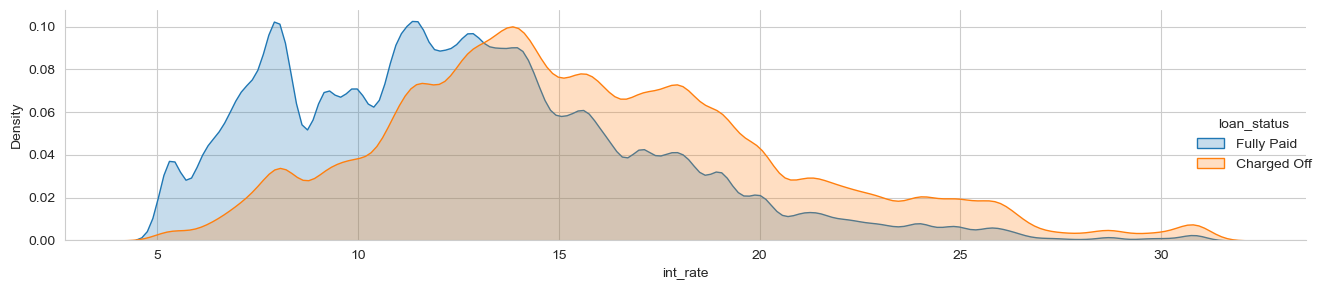

In [234]:
plot_var('int_rate', 'Interest Rate', continuous=True)

In [ ]:
# Installment: Monthly payment owed by the customer if the loan originates

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261655.0,464.749514,262.341293,21.62,275.22,402.83,604.145,1717.63
Fully Paid,1041952.0,431.388962,260.312645,4.93,241.12,368.63,573.060,1719.83


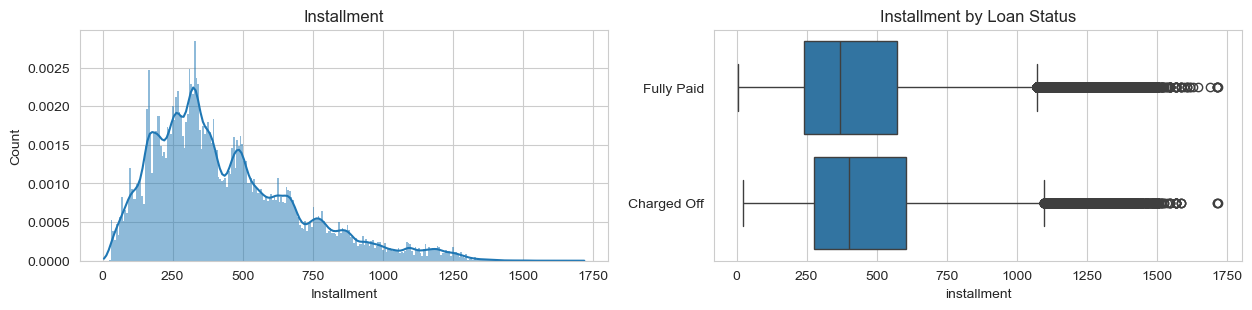

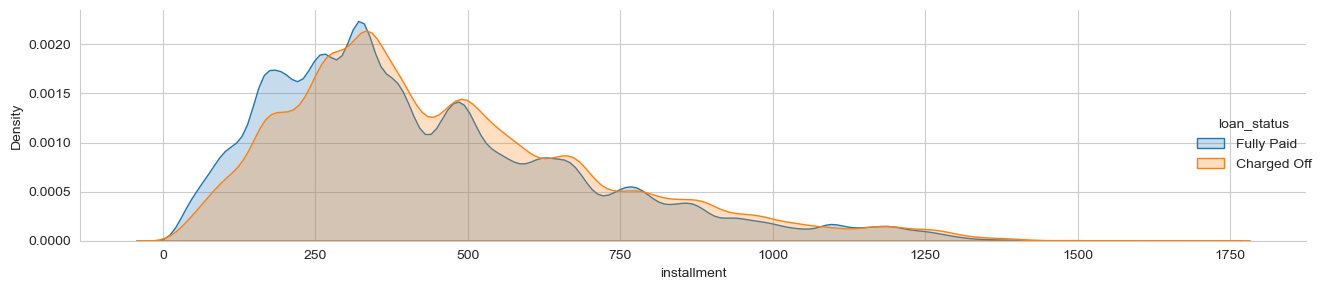

In [235]:
plot_var('installment', 'Installment', continuous = True)
#Charged-off loans tend to have higher installments but the difference of the mean values is very small(465 Vs 431)
df.groupby('loan_status')['installment'].describe()

In [237]:
#6.Emp_Length: "Employment length in years. Possible values are between 0 and 10"
df['emp_length'].value_counts(dropna=False).sort_index()

emp_length
1 year        85677
10+ years    428547
2 years      117820
3 years      104200
4 years       78029
5 years       81623
6 years       60933
7 years       58145
8 years       59125
9 years       49504
< 1 year     104550
NaN           75454
Name: count, dtype: int64

In [238]:
#df['emp_length'].replace('10+ years', '10 years', inplace=True)
df.loc[df["emp_length"] == "10+ years", "emp_length"] = "10"
#df['emp_length'].replace('< 1 year', '0 years', inplace=True)
df.loc[df["emp_length"] == "< 1 year", "emp_length"] = "0"
#df['emp_length'].value_counts(dropna=False).sort_index()


In [239]:
df.emp_length.map( lambda x: str(x).split()[0]).value_counts(dropna=True).sort_index()

emp_length
0      104550
1       85677
10     428547
2      117820
3      104200
4       78029
5       81623
6       60933
7       58145
8       59125
9       49504
nan     75454
Name: count, dtype: int64

In [240]:
df['emp_length'] = df.emp_length.map( lambda x: float(str(x).split()[0]))
df['emp_length'].sample(10)

1510122     NaN
2073086     7.0
2091958    10.0
495244     10.0
1125620    10.0
1041820    10.0
1732644     3.0
1876178    10.0
1079945     9.0
442219      6.0
Name: emp_length, dtype: float64

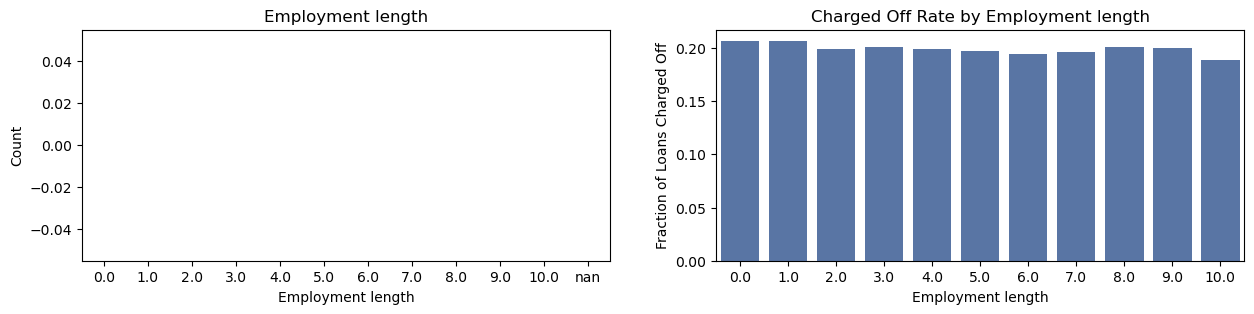

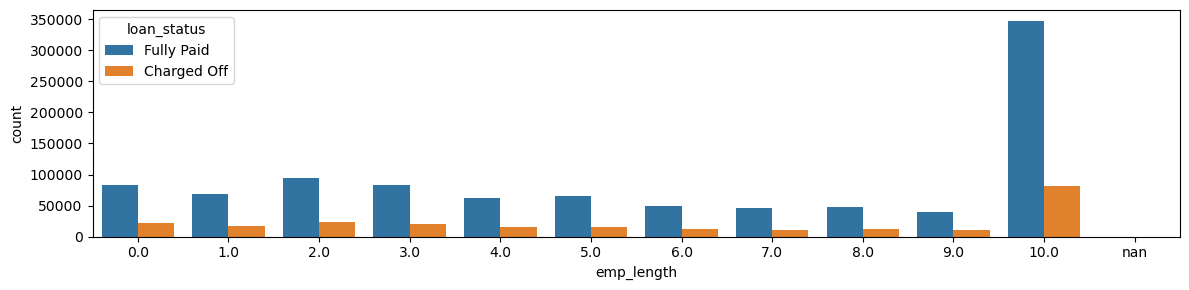

In [189]:
# ~40% of loans go to the people with longer than 10 years of employments
plot_var('emp_length', 'Employment length', continuous=False)

In [125]:
#7.HomeOwnerShip:The home ownership status provided by the borrower during registration or obtained from the credit report
df['home_ownership'].value_counts()

home_ownership
MORTGAGE    645496
RENT        517808
OWN         139844
ANY            267
OTHER          144
NONE            48
Name: count, dtype: int64

In [126]:
df.loc[df["home_ownership"] == 'ANY', "home_ownership"] = "OTHER"
df.loc[df["home_ownership"] == 'NONE', "home_ownership"] = "OTHER"

In [127]:
df['home_ownership'].value_counts()

home_ownership
MORTGAGE    645496
RENT        517808
OWN         139844
OTHER          459
Name: count, dtype: int64

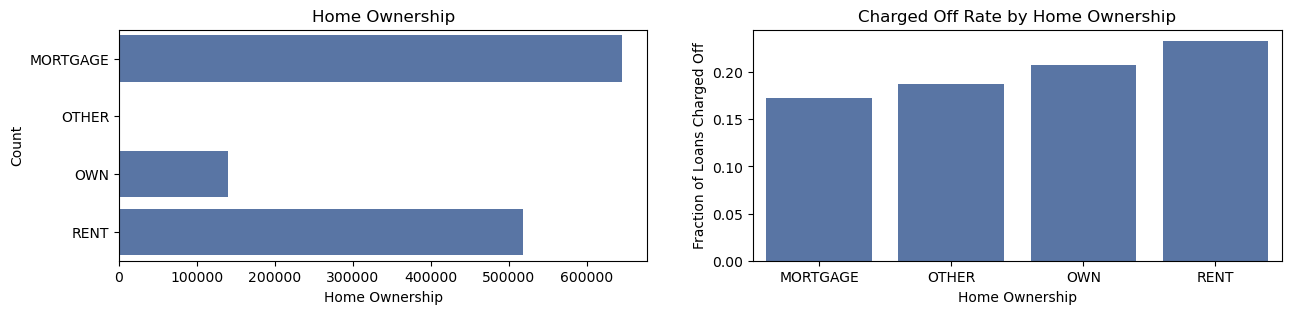

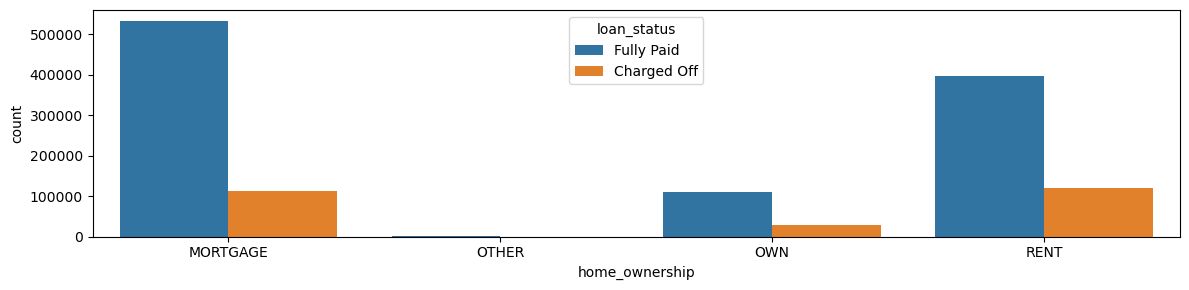

In [197]:
#Mortgage & OTHER has slightly less probability of Charged-Off
plot_var('home_ownership', 'Home Ownership', continuous=False)

In [128]:
#8.Annual Income:"The self-reported annual income provided by the borrower during registration."
df['annual_inc'].describe()

count    1.303607e+06
mean     7.615899e+04
std      7.004890e+04
min      0.000000e+00
25%      4.584000e+04
50%      6.500000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64

In [129]:
df['annual_inc'] = df['annual_inc'].apply(lambda x:np.log10(x+1))
df['annual_inc'].describe()

/var/folders/qb/j7bk_mjs6d73594578vwz43m0000gn/T/ipykernel_13498/4273067220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['annual_inc'] = df['annual_inc'].apply(lambda x:np.log10(x+1))


count    1.303607e+06
mean     4.812791e+00
std      2.453588e-01
min      0.000000e+00
25%      4.661254e+00
50%      4.812920e+00
75%      4.954247e+00
max      7.041361e+00
Name: annual_inc, dtype: float64

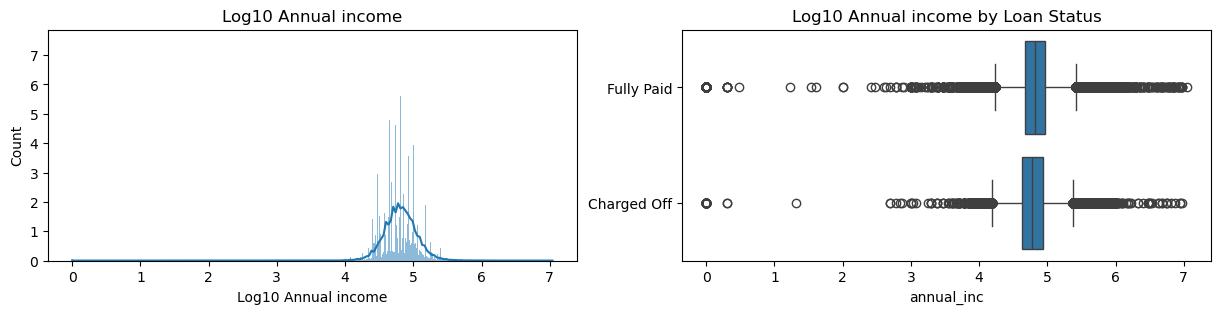

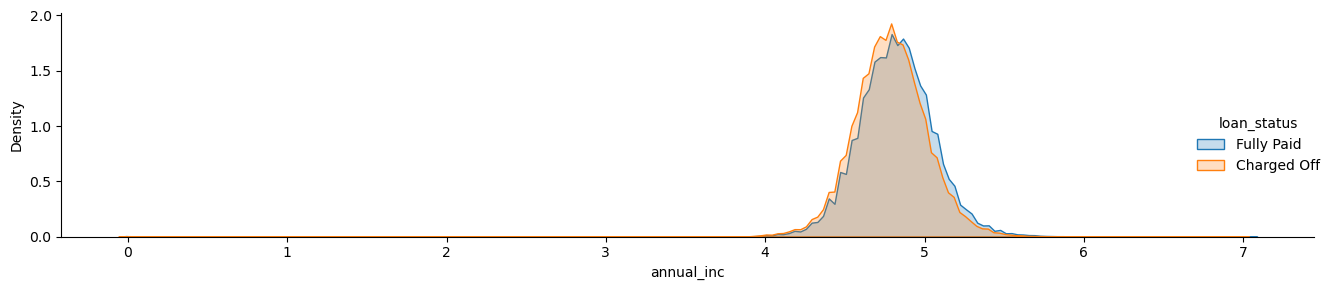

In [200]:
plot_var('annual_inc', 'Log10 Annual income', continuous=True)

In [201]:
#9.VreificationStatus: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

In [130]:
df['verification_status'].value_counts()

verification_status
Source Verified    503726
Verified           407676
Not Verified       392205
Name: count, dtype: int64

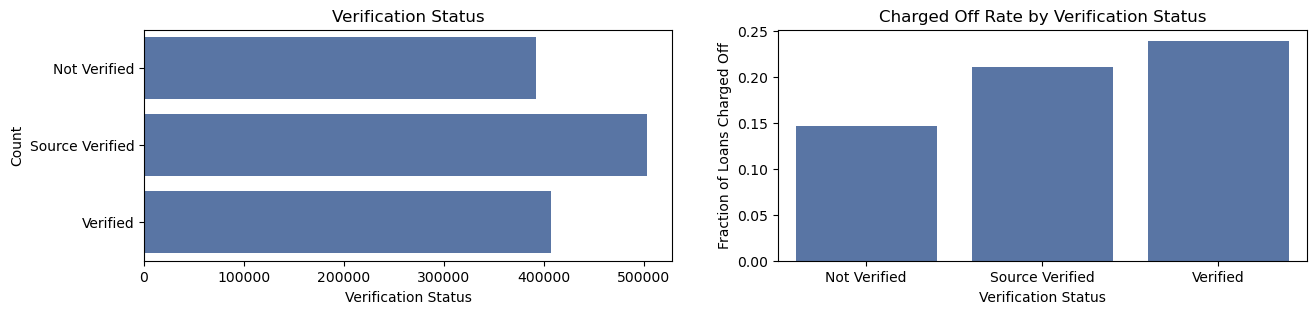

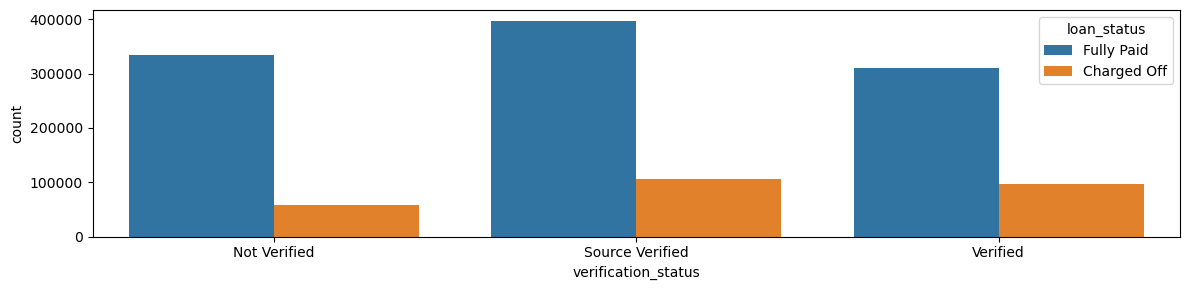

In [203]:
plot_var('verification_status', 'Verification Status', continuous=False)

In [131]:
#10.Purpose: "A category provided by the borrower for the loan request."
df['purpose'].value_counts()

purpose
debt_consolidation    757591
credit_card           285704
home_improvement       84495
other                  74934
major_purchase         28328
medical                15023
small_business         15010
car                    14120
moving                  9172
vacation                8732
house                   6967
wedding                 2294
renewable_energy         911
educational              326
Name: count, dtype: int64

In [132]:
# 29% of the loans for small_business are charged off, but only 12% of wedding are charged Off.
df.groupby('purpose')['loan_status'].value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)

purpose
small_business        0.297468
renewable_energy      0.237102
moving                0.234409
medical               0.219064
house                 0.217167
debt_consolidation    0.212567
other                 0.211706
vacation              0.192396
major_purchase        0.187235
home_improvement      0.178531
educational           0.171779
credit_card           0.170267
car                   0.146388
wedding               0.121622
Name: proportion, dtype: float64

In [242]:
drop_cols('policy_code')

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303607 entries, 100 to 2260664
Data columns (total 25 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1303607 non-null  int64  
 1   term                  1303607 non-null  int8   
 2   int_rate              1303607 non-null  float64
 3   installment           1303607 non-null  float64
 4   sub_grade             1303607 non-null  object 
 5   emp_length            1228153 non-null  float64
 6   home_ownership        1303607 non-null  object 
 7   annual_inc            1303607 non-null  float64
 8   verification_status   1303607 non-null  object 
 9   issue_d               1303607 non-null  object 
 10  loan_status           1303607 non-null  object 
 11  purpose               1303607 non-null  object 
 12  dti                   1303295 non-null  float64
 13  earliest_cr_line      1303607 non-null  object 
 14  open_acc              1303607 non-nul

In [135]:
#11 dti:  "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations"
df['dti'].describe()

count    1.303295e+06
mean     1.825875e+01
std      1.093849e+01
min     -1.000000e+00
25%      1.179000e+01
50%      1.761000e+01
75%      2.404000e+01
max      9.990000e+02
Name: dti, dtype: float64

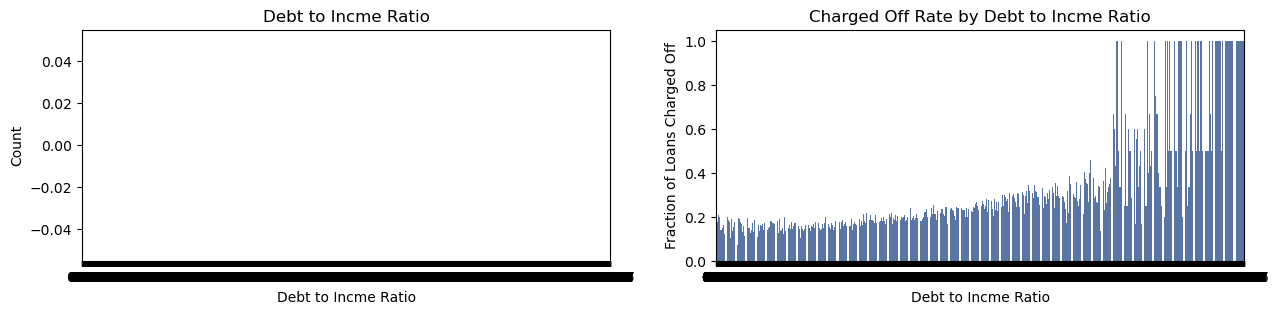

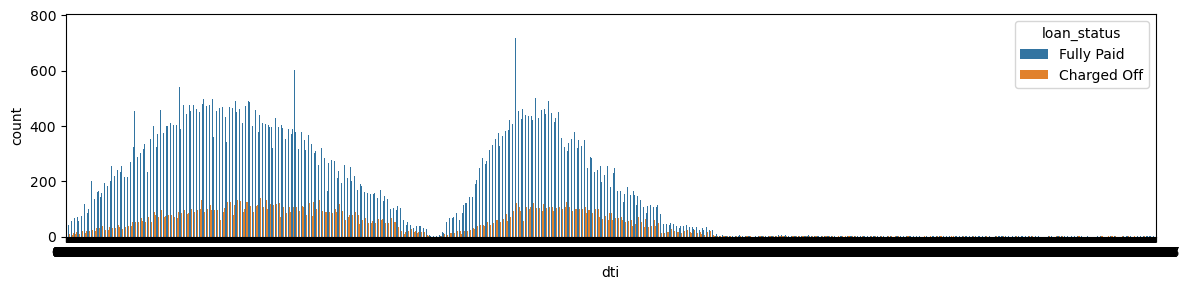

In [209]:
plot_var('dti', 'Debt to Incme Ratio', continuous=True)

In [244]:
#borrowers who have higher DTI are more likely to be charged off
df.groupby('loan_status')['dti'].median()

loan_status
Charged Off    19.77
Fully Paid     17.09
Name: dti, dtype: float64

In [245]:
#earliest_cr_line: "The month the borrower's earliest reported credit line was opened."
df['earliest_cr_line'].sample(5)

1106044    Mar-1986
2011595    Mar-2004
1145949    Oct-1989
1581294    Mar-2014
2114653    Aug-2001
Name: earliest_cr_line, dtype: object

In [246]:
df['earliest_cr_line'].isnull().any()

False

In [247]:
from datetime import datetime

df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)

dttoday = datetime.now().strftime('%Y-%m-%d')
df.earliest_cr_line = df.earliest_cr_line.apply(lambda x:(np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)

df.earliest_cr_line.shape

/var/folders/qb/j7bk_mjs6d73594578vwz43m0000gn/T/ipykernel_13498/2604738858.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)


(1303607,)

In [248]:
df.earliest_cr_line.sample(5)

656477     28.695890
2087229    15.273973
1585661    20.191781
1005046    17.443836
1228533    32.200000
Name: earliest_cr_line, dtype: float64

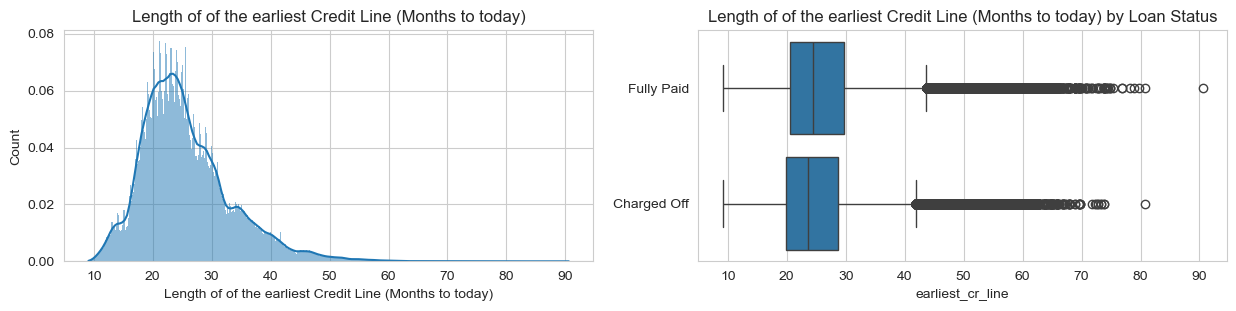

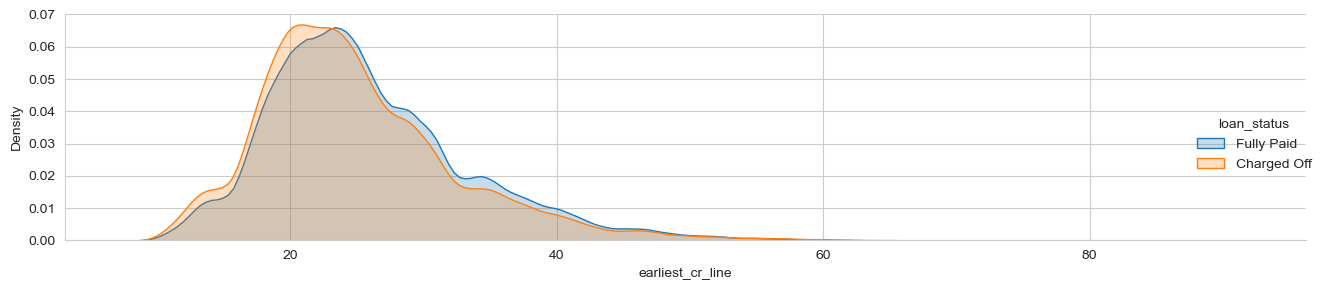

In [249]:
plot_var('earliest_cr_line', 'Length of of the earliest Credit Line (Months to today)', continuous=True)

In [250]:
#pub_rec: Number of derogatory public records
df['pub_rec'].describe()

count    1.303607e+06
mean     2.155220e-01
std      6.028619e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.600000e+01
Name: pub_rec, dtype: float64

In [251]:
df['pub_rec'].value_counts().sort_values(ascending=False)

pub_rec
0.0     1082511
1.0      185104
2.0       23744
3.0        7166
4.0        2533
5.0        1224
6.0         616
7.0         274
8.0         155
9.0          80
10.0         56
11.0         37
12.0         27
13.0         18
15.0          9
21.0          6
18.0          6
16.0          5
19.0          5
14.0          5
20.0          3
17.0          3
28.0          3
24.0          2
22.0          2
49.0          2
23.0          1
61.0          1
47.0          1
46.0          1
37.0          1
54.0          1
86.0          1
25.0          1
40.0          1
63.0          1
34.0          1
Name: count, dtype: int64

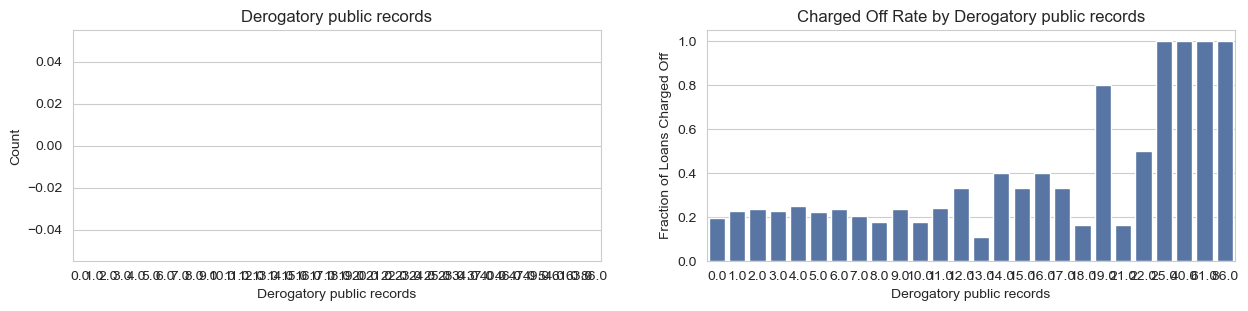

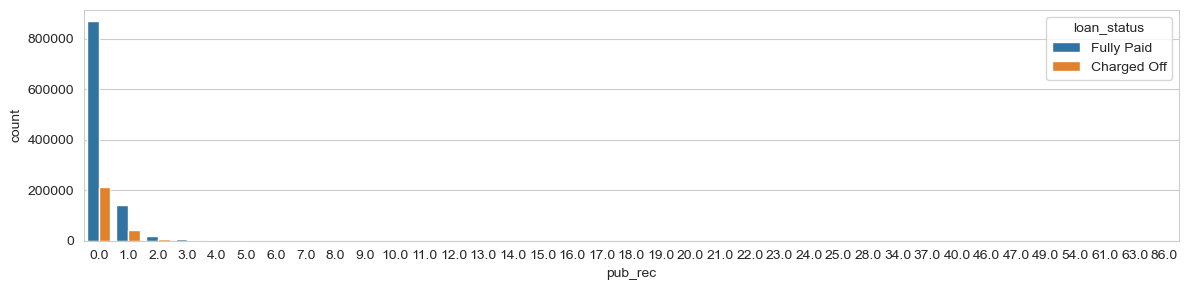

In [252]:
plot_var('pub_rec','Derogatory public records', continuous=False)

In [253]:
df.pub_rec = df.pub_rec.map(lambda x: 3 if x >2.0 else x)

In [254]:
df['pub_rec'].value_counts().sort_values(ascending=False)

pub_rec
0.0    1082511
1.0     185104
2.0      23744
3.0      12248
Name: count, dtype: int64

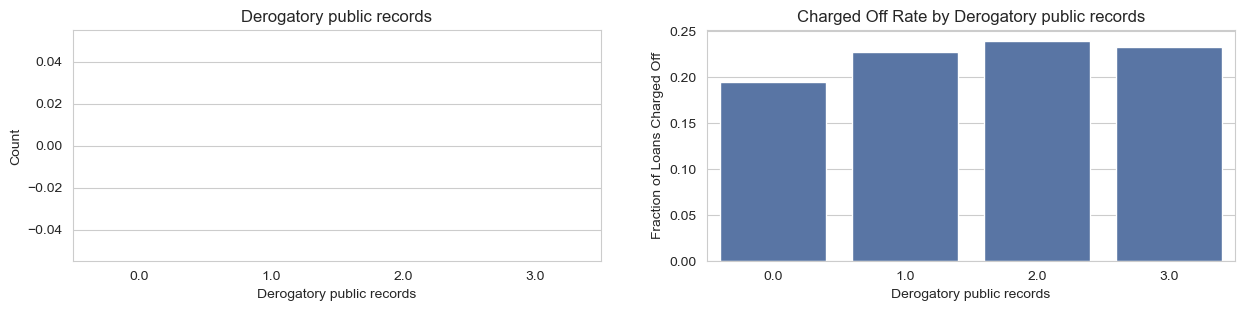

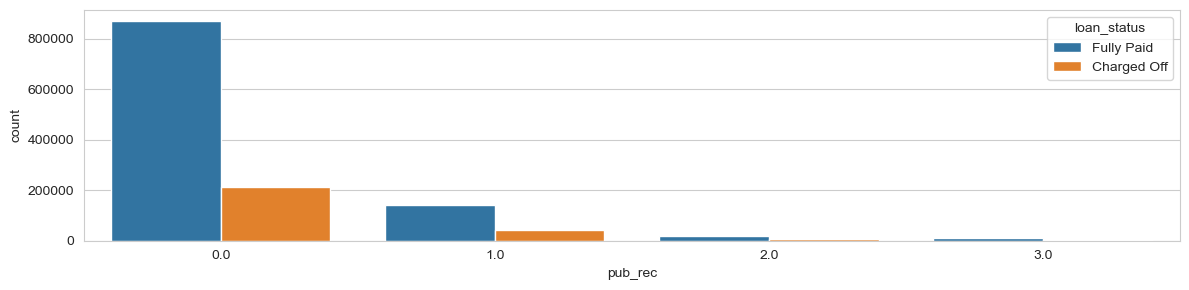

In [255]:
plot_var('pub_rec','Derogatory public records', continuous=False)

In [259]:
df.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261655.0,0.236659,0.537901,0.0,0.0,0.0,0.0,3.0
Fully Paid,1041952.0,0.199062,0.498246,0.0,0.0,0.0,0.0,3.0


In [261]:
# Next, I will convert the "loan_status" column to a 0/1 "charged off" column. Fully Paid:0 Charged Off: 1
df['Charged_Off'] = df['loan_status'].apply(lambda s: float(s == 'Charged Off'))
drop_cols('loan_status')

In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303607 entries, 100 to 2260664
Data columns (total 25 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1303607 non-null  int64  
 1   term                  1303607 non-null  int8   
 2   int_rate              1303607 non-null  float64
 3   installment           1303607 non-null  float64
 4   sub_grade             1303607 non-null  object 
 5   emp_length            1228153 non-null  float64
 6   home_ownership        1303607 non-null  object 
 7   annual_inc            1303607 non-null  float64
 8   verification_status   1303607 non-null  object 
 9   issue_d               1303607 non-null  object 
 10  purpose               1303607 non-null  object 
 11  dti                   1303295 non-null  float64
 12  earliest_cr_line      1303607 non-null  float64
 13  open_acc              1303607 non-null  float64
 14  pub_rec               1303607 non-nul

In [263]:
list_float = df.select_dtypes(exclude=['object']).columns

In [264]:
def run_KS_test(feature):
    dist1 = df.loc[df.Charged_Off == 0,feature]
    dist2 = df.loc[df.Charged_Off == 1,feature]
    print(feature+':')
    print(ks_2samp(dist1,dist2),'\n')

In [265]:
from statsmodels.stats.proportion import proportions_ztest
def run_proportion_Z_test(feature):
    dist1 = df.loc[df.Charged_Off == 0, feature]
    dist2 = df.loc[df.Charged_Off == 1, feature]
    n1 = len(dist1)
    p1 = dist1.sum()
    n2 = len(dist2)
    p2 = dist2.sum()
    z_score, p_value = proportions_ztest([p1, p2], [n1, n2])
    print(feature+':')
    print('z-score = {}; p-value = {}'.format(z_score, p_value),'\n')

In [266]:
from scipy.stats import chi2_contingency
def run_chi2_test(df, feature):

    dist1 = df.loc[df.loan_status == 'Fully Paid',feature].value_counts().sort_index().tolist()
    dist2 = df.loc[df.loan_status == 'Charged Off',feature].value_counts().sort_index().tolist()
    chi2, p, dof, expctd = chi2_contingency([dist1,dist2])
    print(feature+':')
    print("chi-square test statistic:", chi2)
    print("p-value", p, '\n')

In [267]:
for i in list_float:
    run_KS_test(i)  

loan_amnt:
KstestResult(statistic=0.08289190324017615, pvalue=0.0, statistic_location=10000, statistic_sign=1) 

term:
KstestResult(statistic=0.18796284632722182, pvalue=0.0, statistic_location=36, statistic_sign=1) 

int_rate:
KstestResult(statistic=0.2661836737181286, pvalue=0.0, statistic_location=13.17, statistic_sign=1) 

installment:
KstestResult(statistic=0.07090581986187877, pvalue=0.0, statistic_location=334.81, statistic_sign=1) 

emp_length:
KstestResult(statistic=nan, pvalue=nan, statistic_location=nan, statistic_sign=nan) 

annual_inc:
KstestResult(statistic=0.07209317210117083, pvalue=0.0, statistic_location=65974.0, statistic_sign=-1) 

dti:
KstestResult(statistic=nan, pvalue=nan, statistic_location=nan, statistic_sign=nan) 

earliest_cr_line:
KstestResult(statistic=0.05517552286553978, pvalue=0.0, statistic_location=22.942465753424656, statistic_sign=-1) 

open_acc:
KstestResult(statistic=0.029875498158853764, pvalue=1.3361512977221588e-162, statistic_location=10.0, sta

In [ ]:
#it seems that all of these features have different distributions for Fully Paid/Charged Off.

In [271]:
#Pearson Corelation
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303607 entries, 100 to 2260664
Data columns (total 25 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1303607 non-null  int64  
 1   term                  1303607 non-null  int8   
 2   int_rate              1303607 non-null  float64
 3   installment           1303607 non-null  float64
 4   sub_grade             1303607 non-null  object 
 5   emp_length            1228153 non-null  float64
 6   home_ownership        1303607 non-null  object 
 7   annual_inc            1303607 non-null  float64
 8   verification_status   1303607 non-null  object 
 9   issue_d               1303607 non-null  object 
 10  purpose               1303607 non-null  object 
 11  dti                   1303295 non-null  float64
 12  earliest_cr_line      1303607 non-null  float64
 13  open_acc              1303607 non-null  float64
 14  pub_rec               1303607 non-nul

In [277]:

list_float = df.select_dtypes(exclude=['object']).columns
list_float

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'annual_inc', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies',
       'Charged_Off'],
      dtype='object')

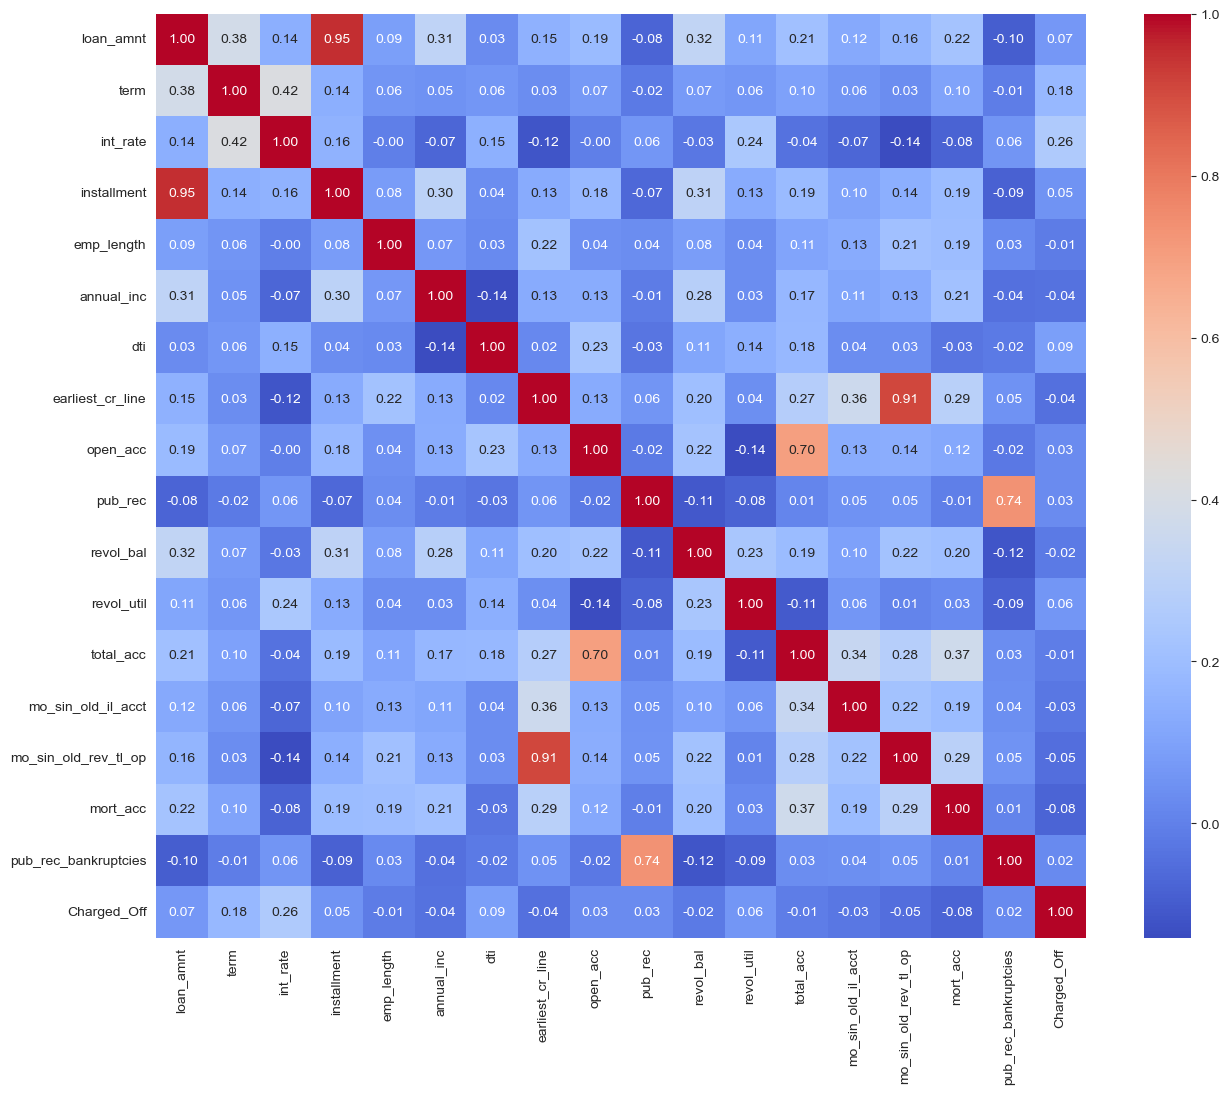

In [269]:
fig, ax = plt.subplots(figsize=(15,12))         # Sample figsize in inches
cm_df = sns.heatmap(df[list_float].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

In [278]:
cor = df[list_float].corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.1) | (cor < -0.1)]

term                  loan_amnt               0.381541
int_rate              loan_amnt               0.143817
                      term                    0.418480
installment           loan_amnt               0.953352
                      term                    0.143206
                      int_rate                0.155512
annual_inc            loan_amnt               0.310231
                      installment             0.300992
dti                   int_rate                0.148388
                      annual_inc             -0.141383
earliest_cr_line      loan_amnt               0.149147
                      int_rate               -0.116542
                      installment             0.130168
                      emp_length              0.215665
                      annual_inc              0.127422
open_acc              loan_amnt               0.186319
                      installment             0.176548
                      annual_inc              0.133669
          

In [280]:
df[["installment","loan_amnt","mo_sin_old_rev_tl_op","earliest_cr_line","total_acc","open_acc", "pub_rec_bankruptcies", "pub_rec"]].isnull().any()

installment             False
loan_amnt               False
mo_sin_old_rev_tl_op     True
earliest_cr_line        False
total_acc               False
open_acc                False
pub_rec_bankruptcies     True
pub_rec                 False
dtype: bool

In [282]:
list_linear = ['installment', 'mo_sin_old_rev_tl_op','total_acc','pub_rec_bankruptcies']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303607 entries, 100 to 2260664
Data columns (total 25 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1303607 non-null  int64  
 1   term                  1303607 non-null  int8   
 2   int_rate              1303607 non-null  float64
 3   installment           1303607 non-null  float64
 4   sub_grade             1303607 non-null  object 
 5   emp_length            1228153 non-null  float64
 6   home_ownership        1303607 non-null  object 
 7   annual_inc            1303607 non-null  float64
 8   verification_status   1303607 non-null  object 
 9   issue_d               1303607 non-null  object 
 10  purpose               1303607 non-null  object 
 11  dti                   1303295 non-null  float64
 12  earliest_cr_line      1303607 non-null  float64
 13  open_acc              1303607 non-null  float64
 14  pub_rec               1303607 non-nul

In [284]:
linear_corr = pd.DataFrame()
# Pearson coefficients
for col in df[list_float].columns:
    linear_corr.loc[col, 'pearson_corr'] = df[col].corr(df['Charged_Off'])
linear_corr['abs_pearson_corr'] = abs(linear_corr['pearson_corr'])

In [285]:
linear_corr.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_corr.drop('abs_pearson_corr', axis=1, inplace=True)
linear_corr.drop('Charged_Off', axis=0, inplace=True)

In [286]:
linear_corr.reset_index(inplace=True)
linear_corr

,index,pearson_corr
0,int_rate,0.258412
1,term,0.175899
2,dti,0.087174
3,mort_acc,-0.075841
4,loan_amnt,0.065217
5,revol_util,0.061077
6,installment,0.051183
7,mo_sin_old_rev_tl_op,-0.050768
8,earliest_cr_line,-0.044364
9,annual_inc,-0.041716


In [287]:
#Drop the linear correlated features
drop_cols(list_linear)

In [288]:
df.shape

(1303607, 21)

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303607 entries, 100 to 2260664
Data columns (total 21 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   loan_amnt            1303607 non-null  int64  
 1   term                 1303607 non-null  int8   
 2   int_rate             1303607 non-null  float64
 3   sub_grade            1303607 non-null  object 
 4   emp_length           1228153 non-null  float64
 5   home_ownership       1303607 non-null  object 
 6   annual_inc           1303607 non-null  float64
 7   verification_status  1303607 non-null  object 
 8   issue_d              1303607 non-null  object 
 9   purpose              1303607 non-null  object 
 10  dti                  1303295 non-null  float64
 11  earliest_cr_line     1303607 non-null  float64
 12  open_acc             1303607 non-null  float64
 13  pub_rec              1303607 non-null  float64
 14  revol_bal            1303607 non-null  int64  
 15  r

In [290]:
df.sample(5)

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,initial_list_status,application_type,mo_sin_old_il_acct,mort_acc,Charged_Off
1229478,23500,60,10.99,B4,10.0,RENT,47000.0,Source Verified,May-2015,debt_consolidation,25.08,24.778082,23.0,0.0,14052,30.6,w,Individual,129.0,0.0,0.0
937618,12000,36,8.38,B1,1.0,RENT,40000.0,Source Verified,Dec-2015,debt_consolidation,18.17,25.693151,3.0,0.0,7083,84.3,w,Individual,202.0,0.0,0.0
1938756,19375,60,12.49,B5,3.0,MORTGAGE,54000.0,Source Verified,Oct-2014,debt_consolidation,12.69,29.284932,4.0,0.0,17615,92.7,f,Individual,NaN,2.0,1.0
1771932,10000,36,14.33,C1,NaN,MORTGAGE,55000.0,Verified,May-2013,home_improvement,3.27,32.284932,8.0,1.0,5006,39.1,f,Individual,NaN,1.0,0.0
1821786,20000,36,7.90,A4,10.0,MORTGAGE,84000.0,Not Verified,Nov-2012,debt_consolidation,8.76,25.945205,14.0,0.0,26214,39.3,f,Individual,135.0,1.0,0.0


In [292]:
missing_values_table(df)

Your selected dataframe has 21 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values,type
mo_sin_old_il_acct,104295,8.0,float64
emp_length,75454,5.8,float64
mort_acc,47281,3.6,float64
revol_util,810,0.1,float64
dti,312,0.0,float64


In [293]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303607 entries, 100 to 2260664
Data columns (total 21 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   loan_amnt            1303607 non-null  int64  
 1   term                 1303607 non-null  int8   
 2   int_rate             1303607 non-null  float64
 3   sub_grade            1303607 non-null  object 
 4   emp_length           1228153 non-null  float64
 5   home_ownership       1303607 non-null  object 
 6   annual_inc           1303607 non-null  float64
 7   verification_status  1303607 non-null  object 
 8   issue_d              1303607 non-null  object 
 9   purpose              1303607 non-null  object 
 10  dti                  1303295 non-null  float64
 11  earliest_cr_line     1303607 non-null  float64
 12  open_acc             1303607 non-null  float64
 13  pub_rec              1303607 non-null  float64
 14  revol_bal            1303607 non-null  int64  
 15  r

In [294]:

dummy_list =['sub_grade','home_ownership','verification_status','purpose','initial_list_status','application_type']

In [295]:
df[dummy_list].isnull().any()

sub_grade              False
home_ownership         False
verification_status    False
purpose                False
initial_list_status    False
application_type       False
dtype: bool

In [296]:
df = pd.get_dummies(df, columns=dummy_list, drop_first=True)

In [297]:
df.shape

(1303607, 71)

In [298]:
#drop_cols('loan_status')
df.head(1)

,loan_amnt,term,int_rate,emp_length,annual_inc,issue_d,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,mo_sin_old_il_acct,mort_acc,Charged_Off,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_Joint App
100,30000,36,22.35,5.0,100000.0,Dec-2018,30.46,12.769863,11.0,1.0,15603,37.0,83.0,1.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True


In [ ]:
#missing_values_table(df)

In [299]:
#Test/Train Split using issue_d
df['issue_d'].sample()

723676    Mar-2016
Name: issue_d, dtype: object

In [300]:
df['issue_d'].isnull().any()

False

In [301]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

/var/folders/qb/j7bk_mjs6d73594578vwz43m0000gn/T/ipykernel_13498/3004380484.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'])


In [302]:
df['issue_d'].sample()

616907   2016-06-01
Name: issue_d, dtype: datetime64[ns]

In [303]:
df['issue_d'].describe()

count                          1303607
mean     2015-05-20 00:47:09.326322432
min                2007-06-01 00:00:00
25%                2014-06-01 00:00:00
50%                2015-07-01 00:00:00
75%                2016-06-01 00:00:00
max                2018-12-01 00:00:00
Name: issue_d, dtype: object

Text(0.5, 1.0, 'Loans funded per Year')

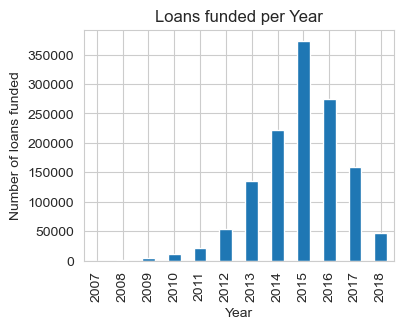

In [304]:
plt.figure(figsize=(4,3))
df['issue_d'].dt.year.value_counts().sort_index().plot.bar()
plt.xlabel('Year')
plt.ylabel('Number of loans funded')
plt.title('Loans funded per Year')

In [305]:
df_train = df.loc[df['issue_d']  < df['issue_d'].quantile(0.8)]
df_test =  df.loc[df['issue_d'] >= df['issue_d'].quantile(0.8)]

In [306]:
print('Number of loans in the partition:   ', df_train.shape[0] + df_test.shape[0])
print('Number of loans in the full dataset:', df.shape[0])

Number of loans in the partition:    1303607
Number of loans in the full dataset: 1303607


In [307]:
df_train['issue_d'].describe()

count                          1042543
mean     2014-11-11 02:35:32.721240576
min                2007-06-01 00:00:00
25%                2014-03-01 00:00:00
50%                2015-03-01 00:00:00
75%                2015-11-01 00:00:00
max                2016-09-01 00:00:00
Name: issue_d, dtype: object

In [308]:
df_test['issue_d'].describe()

count                           261064
mean     2017-06-16 11:39:03.039255040
min                2016-10-01 00:00:00
25%                2017-01-01 00:00:00
50%                2017-06-01 00:00:00
75%                2017-11-01 00:00:00
max                2018-12-01 00:00:00
Name: issue_d, dtype: object

In [309]:
df_train.drop('issue_d', axis=1, inplace=True)
df_test.drop('issue_d', axis=1, inplace=True)

/var/folders/qb/j7bk_mjs6d73594578vwz43m0000gn/T/ipykernel_13498/2346368712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop('issue_d', axis=1, inplace=True)
/var/folders/qb/j7bk_mjs6d73594578vwz43m0000gn/T/ipykernel_13498/2346368712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop('issue_d', axis=1, inplace=True)


In [310]:
X_train = df_train.drop(['Charged_Off'], axis=1)
y_train = df_train.loc[:, 'Charged_Off']

X_test = df_test.drop(['Charged_Off'], axis=1)
y_test = df_test['Charged_Off']

In [311]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1042543 entries, 495243 to 2139270
Data columns (total 70 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1042543 non-null  int64  
 1   term                                 1042543 non-null  int8   
 2   int_rate                             1042543 non-null  float64
 3   emp_length                           986143 non-null   float64
 4   annual_inc                           1042543 non-null  float64
 5   dti                                  1042519 non-null  float64
 6   earliest_cr_line                     1042543 non-null  float64
 7   open_acc                             1042543 non-null  float64
 8   pub_rec                              1042543 non-null  float64
 9   revol_bal                            1042543 non-null  int64  
 10  revol_util                           1041977 non-null  float64
 11

In [312]:
# Imputing missing values
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')
# Train on the training features
imputer.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [313]:
missing_values_table(X_train)

Your selected dataframe has 69 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,type


In [314]:
missing_values_table(X_test)

Your selected dataframe has 69 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,type


In [315]:
from sklearn.preprocessing import StandardScaler

In [316]:
#Feature Scaling
# Create an imputer object with a median filling strategy
scaler = StandardScaler()

# Train on the training features
scaler.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [317]:
y_test.isnull().any()

False

In [318]:
#6.5 PCA visualization of the train data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train.values)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [319]:
principalDf.head(5)

,principal component 1,principal component 2
0,-0.078641,1.214117
1,0.910912,-2.193810
2,2.500671,1.466197
3,-3.766602,-1.783423
4,-0.904578,0.750124


In [320]:
y_train_df = pd.DataFrame(data=y_train.values, columns=['Charged_Off'])

In [321]:
finalDf = pd.concat([principalDf, y_train_df], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,Charged_Off
0,-0.078641,1.214117,1.0
1,0.910912,-2.193810,0.0
2,2.500671,1.466197,0.0
3,-3.766602,-1.783423,0.0
4,-0.904578,0.750124,0.0


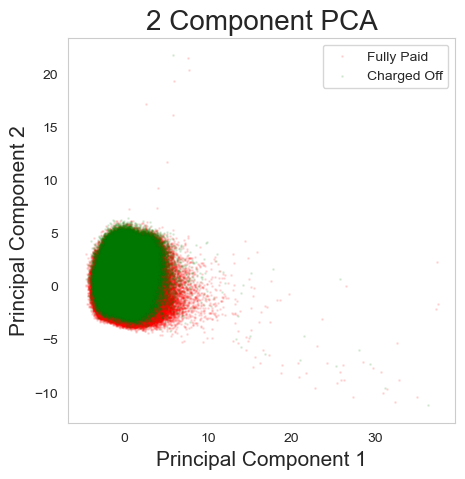

In [322]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Charged_Off'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 1, alpha=0.1)
ax.legend(['Fully Paid', 'Charged Off'])
ax.grid()

In [323]:
pca.explained_variance_ratio_

array([0.04422395, 0.03887056])

In [324]:
# Linear dependence of Charged_Off
linear_corr = pd.DataFrame()
# Pearson coefficients
for col in X_train.columns:
    linear_corr.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
    
linear_corr['abs_pearson_corr'] = abs(linear_corr['pearson_corr'])

In [325]:
linear_corr.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_corr.drop('abs_pearson_corr', axis=1, inplace=True)
linear_corr.reset_index(inplace=True)
linear_corr.head(10)

,index,pearson_corr
0,dti,0.006637
1,mo_sin_old_il_acct,-0.006531
2,sub_grade_A4,-0.005845
3,int_rate,0.005807
4,sub_grade_D3,-0.005352
5,initial_list_status_w,0.005297
6,sub_grade_F5,0.005182
7,verification_status_Verified,0.004590
8,sub_grade_C4,0.004350
9,open_acc,0.004332


In [326]:
linear_corr.tail(10)

,index,pearson_corr
59,home_ownership_MORTGAGE,3.824129e-04
60,purpose_credit_card,-3.655156e-04
61,purpose_wedding,-3.047155e-04
62,sub_grade_F4,-2.745865e-04
63,annual_inc,2.539170e-04
64,sub_grade_E2,1.856647e-04
65,sub_grade_G4,-1.062984e-04
66,home_ownership_NONE,-8.964013e-05
67,sub_grade_G2,3.283664e-05
68,application_type_Joint App,6.302524e-18


##Modelling
Following Models are used to evaluate, with CrossValidation(test-tran-split)
- Logistic regression with SGD training
- Random Forest
- KNN

In [329]:
# CV model with Kfold stratified cross val
kfold = 3
random_state = 42

In [330]:
#logistic regression with stochastic gradient descent training.
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

In [335]:
pipeline_sgdlr = Pipeline([
    ('model', SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=random_state, warm_start=True))
])

In [336]:
param_grid_sgdlr  = {
    'model__alpha': [10**-5, 10**-1, 10**2],
    'model__penalty': ['l1', 'l2']
}

In [337]:
grid_sgdlr = GridSearchCV(estimator=pipeline_sgdlr, param_grid=param_grid_sgdlr, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=kfold, verbose=1, return_train_score=False)
grid_sgdlr.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model',
                                        SGDClassifier(loss='log_loss',
                                                      random_state=42,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'model__alpha': [1e-05, 0.1, 100],
                         'model__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [339]:
sgdlr_estimator = grid_sgdlr.best_estimator_
print('Best score: ', grid_sgdlr.best_score_)
print('Best parameters set: \n', grid_sgdlr.best_params_)

Best score:  0.7056914881586985
Best parameters set: 
 {'model__alpha': 0.1, 'model__penalty': 'l2'}


In [340]:
##RandomForest
from sklearn.ensemble import RandomForestClassifier

In [341]:
rf = RandomForestClassifier(n_jobs=-1, random_state=random_state, max_features= 'sqrt' ,n_estimators=50) 
param_grid_rf = {
    'n_estimators': [50], # The number of randomized trees to build 
    'class_weight': [{0:1, 1:1}] #'model__class_weight': [{0:1, 1:1}, {0:1,1:2}, {0:1, 1:3}, {0:1, 1:4}]
   # 'model__max_features': range(2,7),
   # 'model__min_samples_leaf':range(2,6),
}

In [342]:
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='roc_auc',n_jobs=-1,pre_dispatch='2*n_jobs', cv=kfold, verbose=1, return_train_score=False)
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}], 'n_estimators': [50]},
             scoring='roc_auc', verbose=1)

In [343]:
rf_estimator = grid_rf.best_estimator_
print('Best score: ', grid_rf.best_score_)
print('Best parameters set: \n', grid_rf.best_params_)

Best score:  0.671965059051499
Best parameters set: 
 {'class_weight': {0: 1, 1: 1}, 'n_estimators': 50}


In [345]:
#Feature Importance

names = list(X_train)
feature_importances = pd.DataFrame(grid_rf.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print("Features sorted by their score: Top 10")
feature_importances.head(10)

Features sorted by their score: Top 10


,importance
dti,0.092513
int_rate,0.088693
revol_bal,0.087472
revol_util,0.086206
earliest_cr_line,0.085324
mo_sin_old_il_acct,0.080957
annual_inc,0.080569
loan_amnt,0.074386
open_acc,0.062878
emp_length,0.045410


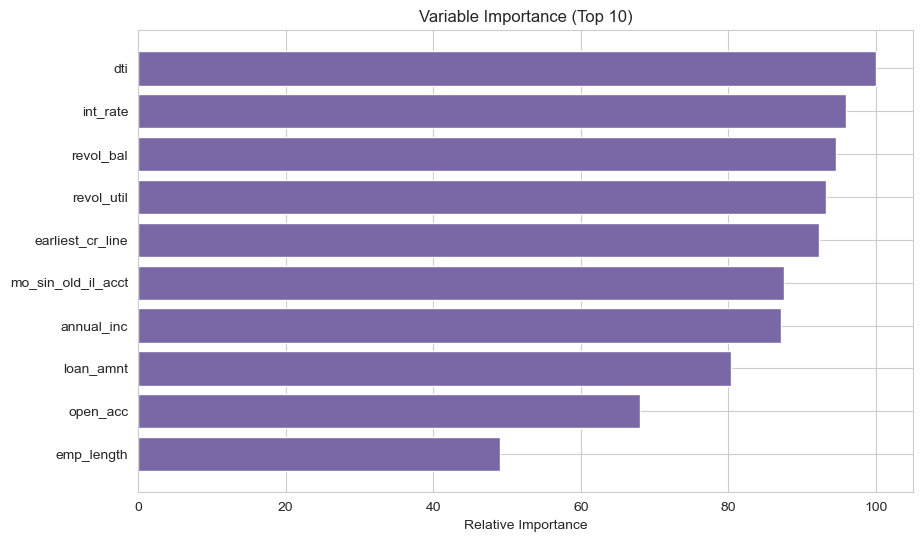

In [346]:
# Normalize The Features and visulize the top 10 features
feature_importance = 100.0 * (grid_rf.best_estimator_.feature_importances_ / grid_rf.best_estimator_.feature_importances_.max())
sorted_idx = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i])[-10:]
pos = np.arange(len(sorted_idx)) + .5
plt.figure(figsize=(10, 6))

plt.barh(pos, feature_importance[sorted_idx], align='center', color='#7A68A6')
plt.yticks(pos, np.asanyarray(X_train.columns.tolist())[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance (Top 10)')
plt.show()

In [347]:
print("Features sorted by their score: Bottom 10")
feature_importances.tail(10)

Features sorted by their score: Bottom 10


,importance
sub_grade_G1,0.000445
purpose_wedding,0.000410
sub_grade_G2,0.000376
sub_grade_G3,0.000284
purpose_renewable_energy,0.000260
sub_grade_G4,0.000221
sub_grade_G5,0.000199
purpose_educational,0.000101
home_ownership_OTHER,0.000045
home_ownership_NONE,0.000016


In [348]:
#Visualizing Single Decision Tree
grid_rf.best_estimator_[1]

DecisionTreeClassifier(max_features='sqrt', random_state=1273642419)

In [358]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
rf_big = RandomForestClassifier(n_jobs=-1, random_state=random_state, n_estimators=10, max_depth=6) 
rf_big.fit(X_train, y_train)

# Pull out one tree from the forest
tree_big = rf_big.estimators_[5]
# Export the image to a dot file
export_graphviz(tree_big, out_file = 'images/big_tree.dot', feature_names = names, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('images/big_tree.dot')
# Write graph to a png file
graph.write_png('big_tree.png')

In [359]:
# Limit depth of tree to 3 levels
rf_small = RandomForestClassifier(n_jobs=-1, random_state=random_state, n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'images/small_tree.dot', feature_names = names, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('images/small_tree.dot')
graph.write_png('small_tree.png')

In [ ]:
#KNN; Will reduce the features for KNN(<10) for performance reasons

In [364]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn import decomposition

#chaining a PCA and a knn
pipeline_knn = Pipeline([
    ('pca', decomposition.PCA()),
    ('model', KNeighborsClassifier(n_jobs=-1))   
])

pipeline_knn2 = Pipeline([
    ('lda', LinearDiscriminantAnalysis()),
    ('model', KNeighborsClassifier(n_jobs=-1))   
])

param_grid_knn = {
    'pca__n_components': [1,3],
    'model__n_neighbors': [5, 25, 125]
}
param_grid_knn2 = {
    'lda__n_components': [1,3],
    'model__n_neighbors': [5, 25, 125]
}


In [365]:
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=kfold, verbose=1, return_train_score=False)
grid_knn2 = GridSearchCV(estimator=pipeline_knn2, param_grid=param_grid_knn2, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=kfold, verbose=1, return_train_score=False)

In [366]:
%%time
grid_knn2.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
9 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 471, in fit
    Xt = self._fit(X, y, ro

CPU times: user 44.8 s, sys: 4.61 s, total: 49.4 s
Wall time: 1min 58s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('lda', LinearDiscriminantAnalysis()),
                                       ('model',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'lda__n_components': [1, 3],
                         'model__n_neighbors': [5, 25, 125]},
             scoring='roc_auc', verbose=1)

In [368]:
knn_estimator2 = grid_knn2.best_estimator_
print('Best score: ', grid_knn2.best_score_)
print('Best parameters set: \n', grid_knn2.best_params_)

Best score:  0.6850548829703861
Best parameters set: 
 {'lda__n_components': 1, 'model__n_neighbors': 125}


/var/folders/qb/j7bk_mjs6d73594578vwz43m0000gn/T/ipykernel_13498/464759305.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(data = auroc_res, y=["SGD Logistic Regression","RandomForest","KNeighbors"], x=auroc_means, palette="Set3",orient = "h")


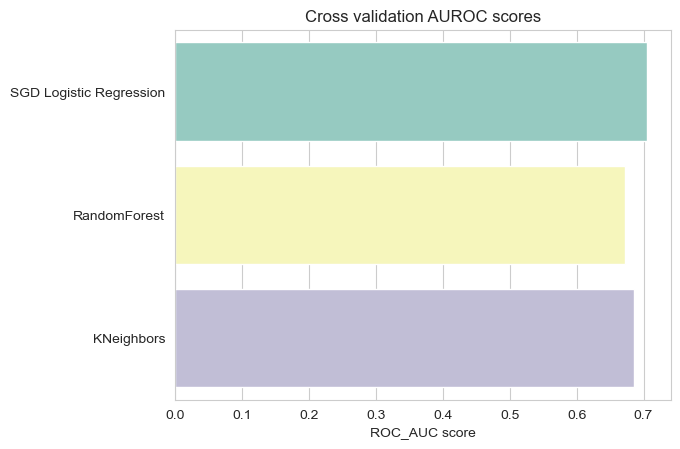

In [376]:
#Hyperparameter tuning for the 3 models
# plot the AUROC scores
auroc_means = [grid_sgdlr.best_score_, grid_rf.best_score_,grid_knn2.best_score_]
auroc_res = pd.DataFrame({"AUROC":auroc_means,"Algorithm":["SGD Logistic Regression",
"RandomForest","KNeighboors"]})

g = sns.barplot(data = auroc_res, y=["SGD Logistic Regression","RandomForest","KNeighbors"], x=auroc_means, palette="Set3",orient = "h")
g.set_xlabel("ROC_AUC score")
g = g.set_title("Cross validation AUROC scores")


In [ ]:
#Logistic Regression provides the best results on the training data and it runs much faster than the other two models as well. 
#Therefore, I will tun the hyperparameters of the logistic regression model

In [377]:
pipeline_sgdlr_hyper = Pipeline([
    ('model', SGDClassifier(loss='log_loss', max_iter=2000, tol=1e-3, random_state=random_state, warm_start=True))
])

In [378]:
param_grid_sgdlr_hyper  = {
    'model__alpha': [10**-5, 10**-3, 10**2],
    'model__penalty': ['l1', 'l2']
}

In [380]:
grid_sgdlr_hyper = GridSearchCV(estimator=pipeline_sgdlr_hyper, param_grid=param_grid_sgdlr_hyper, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
result = grid_sgdlr_hyper.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
Best score:  0.7094119185344374
Best parameters set: 
 {'model__alpha': 0.001, 'model__penalty': 'l2'}

In [381]:
#Test Evaluation
from sklearn.metrics import roc_auc_score

y_pred = grid_sgdlr_hyper.best_estimator_.predict(X_test)
y_prob = grid_sgdlr_hyper.best_estimator_.predict_proba(X_test)[:,1]

score = roc_auc_score(y_test, y_prob)
matrix = metrics.confusion_matrix(y_test, y_pred)


In [382]:
print('Logistic Regression roc_auc score:', (score))

Logistic Regression roc_auc score: 0.6890759690189412


In [384]:
print('Logistic Regression:\n {}\n'.format(metrics.classification_report(y_test, y_pred)))


Logistic Regression:
               precision    recall  f1-score   support

         0.0       0.79      0.97      0.88    204558
         1.0       0.48      0.08      0.14     56506

    accuracy                           0.78    261064
   macro avg       0.64      0.53      0.51    261064
weighted avg       0.73      0.78      0.72    261064




In [385]:
print('Logistic Regression matrix:\n{}\n'.format(matrix))

Logistic Regression matrix:
[[199432   5126]
 [ 51747   4759]]



In [ ]:
#Conclusion
Using ML Algorithms, tried predicting the probability that a charged off loan can be revived with loan adjustments. 
Trained with 3 models (Logistic Regression, random forest and KNN), and found that logistic regression classifier performs the best 
(highest AUROC score of 0.7056) and test dataset came similar score (0.7094) 

Based on the Pearson correlation between the features and the target variable, we must consider the features along ( interest_rate, term, dti) 
along with the others for good predictability.